# Tutorial
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pysmo/pysmo/HEAD?urlpath=%2Fdoc%2Ftree%2Fdocs%2Ffirst-steps%2Ftutorial%2Ftutorial.ipynb)


After reading the [first](https://docs.pysmo.org/first-steps/) section of the documentation you should have a basic understanding of three things:

- How *type annotations* in Python work.
- That defining a class also means you are defining a type.
- How defining types with [`Protocol`](https://docs.python.org/3/library/typing.html#typing.Protocol) classes allows annotating functions without coupling them to one or more normal [classes](https://docs.python.org/3/tutorial/classes.html).

## Introduction to pysmo types

Pysmo makes use of `Protocol` classes not just to make functions and classes work together nicely, but especially also to define types that are relevant in seismologial processing. In this section we show you how to use pysmo types, and illustrate how it enables writing code that is easy to write (and read!), while at the same time also being highly reusable.

### Getting SAC Data

Let's begin by downloading a seismogram and storing it in a Python object. Pysmo has a class called `SAC`, which lets us use [SAC files](https://ds.iris.edu/files/sac-manual/manual/file_format.html) directly in Python. We first import the `SAC` class from pysmo:

In [1]:
from pysmo.classes import SAC

then we use it to download a SAC file from IRIS and create a `SAC` instance named `sac`:

In [2]:
sac = SAC.from_iris(
    net="IU",
    sta="ANMO",
    cha="LHZ",
    loc="00",
    start="2005-03-28T15:00:00",
    duration=3600 * 5,
    scale="AUTO",
    demean="true",
    force_single_result=True,
)

If you are familiar with the SAC file format, you will know that it has a lot of header variables for metadata. For example for the station and event coordinates:

In [3]:
def print_coords(sac):
    print(f"Station coordinates: {sac.stla}/{sac.stlo}")
    print(f"Event coordinates: {sac.evla}/{sac.evlo}")


print_coords(sac)

Station coordinates: None/None
Event coordinates: None/None


Whoops! It appears our SAC file was missing values for these headers. This is not really surprising, as many of the SAC headers are optional fields. Let's fix this before proceeding:

In [4]:
sac.stla, sac.stlo = 34.9462, 106.4567
sac.evla, sac.evlo = 2.09, -97.15

print_coords(sac)

Station coordinates: 34.9462/106.4567
Event coordinates: 2.09/-97.15


### A new seismogram class

Anyone not familiar with the SAC file format could easily be confused or overwhelmed by all the different SAC header fields. Working with a class with more descriptive attribute names is probably easier. A rudimentary class may look something like this:

In [5]:
# %load tutorial_seismogram.py
from dataclasses import dataclass
import numpy as np


@dataclass
class TutorialSeismogram:
    event_latitude: float | None
    event_longitude: float | None
    station_latitude: float | None
    station_longitude: float | None
    delta: float
    data: np.ndarray

Next we create an instance of this class using data from `sac`:

In [6]:
from copy import copy

tseis = TutorialSeismogram(
    event_latitude=sac.evla,
    event_longitude=sac.evlo,
    station_latitude=sac.stla,
    station_longitude=sac.stlo,
    delta=sac.delta,
    data=copy(sac.data),
)

### Using a seismogram in a function

So far so good. Let's use our new object and use it to calculate something. As we now have event and station coordinates, we can use them to determine the great circle distance between them. To do so we write a function (complete with type hints):

In [7]:
# %load calc_gcd_from_seismogram.py
from pyproj import Geod  # We will use the Geod class for the calculations
from tutorial_seismogram import TutorialSeismogram


def calc_gcd_from_seismogram(seismogram: TutorialSeismogram) -> float:
    g = Geod(ellps="WGS84")
    # The g.inv method returns azimuth, back-azimuth and distance (in metres)
    # We only need the distance here:
    _, _, dist = g.inv(
        lons1=seismogram.event_longitude,
        lats1=seismogram.event_latitude,
        lons2=seismogram.station_longitude,
        lats2=seismogram.station_latitude,
    )
    return round(dist / 1000)

Before running the function with our `tsac` object, let's think about what we can infer from the first line of the function definition. Basically it reads: "define a function called `calc_gcd_from_seismogram` that uses data in a variable called `seismogram` (which is of type `TutorialSeismogram`) and return a `float`. That is quite concise, but probably also sounds a bit strange - calculating a distance from a seismogram...? That is because in order to intuitively understand this function, a user needs to have intricate knowlege of the structure of the input object (`TutorialSeismogram`).

Calling the function with our data we get:

In [8]:
distance = calc_gcd_from_seismogram(tseis)
print(f"The great circle distance is {distance} km")

The great circle distance is 15229 km


Great, this worked! However, there are two problems with our implementation:

1. Because the input type is a particular class (i.e. `TutorialSeismogram`) rather than a `Protocol` class, this function only works with that one input type.
2. It will crash when any of the coordinates are `None` (you can test this by downloading the data again and running the function without adding the station and event coordinates first). Given that many of the headers in a SAC file are optional this is a likely scenario that we need to manage in our code.

### A function using only builtin types

Both of these problems can be addressed with a more general implementation using only the built-in `float`:

In [9]:
# %load calc_gcd_from_floats.py
from pyproj import Geod


def calc_gcd_from_floats(
    longitude_1: float, latitude_1: float, longitude_2: float, latitude_2: float
) -> float:
    g = Geod(ellps="WGS84")
    _, _, dist = g.inv(
        lons1=longitude_1, lats1=latitude_1, lons2=longitude_2, lats2=latitude_2
    )
    return round(dist / 1000)

Which reads as: "define a function called `calc_gcd_from_floats` that uses a variable called `longitude_1` (which is a `float`), a variable called `latitude_1` (which is a `float`), a variable called `longitude_2` (which is a `float`), a variable called `latitude_2` (which is a float), and return a `float`". That is not only a bit awkward to read, but also less convenient to use:

In [10]:
distance = calc_gcd_from_floats(
    tseis.event_longitude,
    tseis.event_latitude,
    tseis.station_longitude,
    tseis.station_latitude,
)
print(f"The great circle distance is {distance} km")

The great circle distance is 15229 km


It will, however also work with `SAC` objects:

In [11]:
distance = calc_gcd_from_floats(sac.evlo, sac.evla, sac.stlo, sac.stla)
print(f"The great circle distance is {distance} km")

The great circle distance is 15229 km


### A happy middle ground

The two functions we used could be characterised as being on opposite ends of the spectrum: one function uses a single, somewhat complex object as input, while the other uses only the most fundamental types that are built into Python. Leaving aside any advantages or shortcomings of either approach and just focusing on the task at hand - calculating the distance between two points - we might find a function signature more like this to be easiest to read/understand:

```python
def calc_gcd(point1: Location,
             point2: Location,
            ) -> float: ...
```

`Location` is indeed a type in pysmo, and we could implement the `gcd` function as follows:

In [12]:
# %load calc_gcd_pysmo.py
from pyproj import Geod
from pysmo import Location


def calc_gcd(point1: Location, point2: Location) -> float:
    g = Geod(ellps="WGS84")
    _, _, dist = g.inv(
        lons1=point1.longitude,
        lats1=point1.latitude,
        lons2=point2.longitude,
        lats2=point2.latitude,
    )
    return round(dist / 1000)

`Location` is a `Protocol` class that has just two attributes (which are both `floats`). We can list them like this:

In [13]:
Location.__protocol_attrs__

{'latitude', 'longitude'}

Neither of the two classes above have these attributes, and can therefore not be used as inputs for this function:

In [14]:
isinstance(tseis, Location), isinstance(sac, Location)

(False, False)

You have now reached an important point in this tutorial! It would appear that our nice function with pysmo types cannot be used with our data. Assuming you need to work with two types of seismogram objects (e.g. `SAC` and `TutorialSeismogram`) you have three options going forward:

1. Write the same function two times for each class.
2. Use only built-in types in your functions.
3. Make your classes work with pysmo types.

Given that the number of functions is almost always going to be far greater then the number of classes, (1) doesn't seem reasonable. (2) might seem okay at first, but consider that everytime you want to call a function you will have to write something like this:

```python
if isinstance(seismogram, SAC):
    distance = calc_gcd_from_floats(
    sac_seis.evlo, sac_seis.evla, sac_seis.stlo, sac_seis.stla
    )
elif isinstance(seismogram, TutorialSeismogram):
    distance = calc_gcd_from_floats(
    seismogram.event_longitude,
    seismogram.event_latitude,
    seismogram.station_longitude,
    seismogram.station_latitude,
    )
```

This too is a lot of work, and it will only get worse if more classes need to be added sometime in the future. Moreover, if at any point one of the classes changes (e.g. the names of SAC headers change - though that is probably unlikely to actually happen...), you will have to adjust your code accordingly. Conversely, a `Location` type with only two attributes, `latitude` and `longitude`, is pretty much guaranteed to never change (something to consider even if you are only working with one type).

This leaves the last option - make your classes work with pysmo types. There may be different ways of achieving this, but for this tutorial we show how to modify existing classes to make them work with pysmo types directly.


### Modifying an existing class

The problem we need to solve with our existing `TutorialSeismogram` class is really that two sets of coordinates need to be managed using the same name. In order to use e.g. `station_latitude` as `latitude` we need to map it in a way that doesn't interfere with `event_latitude`. We can do this with what one could call "helper" classes that themselves are attributes of the main class. We define one such class for station data and one for event data:

In [15]:
# %load tutorial_seismogram_pysmo.py
from dataclasses import dataclass, field
from tutorial_seismogram import TutorialSeismogram


@dataclass
class TutorialStation:
    parent: TutorialSeismogram

    @property
    def latitude(self) -> float:
        if self.parent.station_latitude is None:
            raise ValueError("parent value may not be None")
        return self.parent.station_latitude

    @latitude.setter
    def latitude(self, value: float):
        self.parent.station_latitude = value

    @property
    def longitude(self) -> float:
        if self.parent.station_longitude is None:
            raise ValueError("parent value may not be None")
        return self.parent.station_longitude

    @longitude.setter
    def longitude(self, value: float):
        self.parent.station_longitude = value


@dataclass
class TutorialEvent:
    parent: TutorialSeismogram

    @property
    def latitude(self) -> float:
        if self.parent.event_latitude is None:
            raise ValueError("parent value may not be None")
        return self.parent.event_latitude

    @latitude.setter
    def latitude(self, value: float):
        self.parent.event_latitude = value

    @property
    def longitude(self) -> float:
        if self.parent.event_longitude is None:
            raise ValueError("parent value may not be None")
        return self.parent.event_longitude

    @longitude.setter
    def longitude(self, value: float):
        self.parent.event_longitude = value


@dataclass
class TutorialSeismogramPysmo(TutorialSeismogram):
    station: TutorialStation = field(init=False)
    event: TutorialEvent = field(init=False)

    def __post_init__(self) -> None:
        self.station = TutorialStation(parent=self)
        self.event = TutorialEvent(parent=self)

This is a bit of effort upfront, but consider that you only need to do this once! As before we can create an instance of our class from the data in the sac object:

In [16]:
from copy import copy

tseisp = TutorialSeismogramPysmo(
    event_latitude=sac.evla,
    event_longitude=sac.evlo,
    station_latitude=sac.stla,
    station_longitude=sac.stlo,
    delta=sac.delta,
    data=copy(sac.data),
)

And verify that e.g. `tseisp.event_latitude` is the same as `tseisp.event.latitude`:

In [17]:
tseisp.event_latitude == tseisp.event.latitude

True

This is still true after modifying an attribute:

In [18]:
tseisp.event.latitude = 12.34
tseisp.event_latitude == tseisp.event.latitude

True

We can also verify that the helper classes match the `Location` type:

In [19]:
print(f"tseisp.event matches Location type: {isinstance(tseisp.event, Location)}")
print(f"tseisp.station matches Location type: {isinstance(tseisp.station, Location)}")

tseisp.event matches Location type: True
tseisp.station matches Location type: True


Finally, lets run the `calc_gcd()` function with the modified class:

In [20]:
distance = calc_gcd(tseisp.event, tseisp.station)

print(f"The great circle distance is {distance} km")

The great circle distance is 14213 km


That seemed to work!

Spoiler: the `SAC` class already has such helper classes...

In [21]:
distance = calc_gcd(sac.event, sac.station)

print(f"The great circle distance is {distance} km")

The great circle distance is 15229 km


which also map other attributes:

In [22]:
sac.station.name

'ANMO'

### Summary

This example demonstrates how to write functions using pysmo types and what some advantages are:

- Pysmo types are simple and intuitive (e.g. the `Location` type only has two attributes, whereas the `SAC` class has over 100 (due to the large number of header fields specified in the file format.
- Because the types are so simple, values of `None` are typically not allowed in their attributes. A SAC file without event coordinates is still a valid SAC file, whereas a location with no latitude or longitude doesn't make sense.
- The simplicity of the types also results in the functions written with them being useful in more situations. We may have e.g. an `Airport` class we could use with the `calc_gcd()` function to calculate how far apart two airports are.

In conclusion, we believe that a good class for storing data (where we may want to have as much metadata as possible), is not necessarily the best class to use inside functions (where we only use a small portion of the data stored in the class). The best way to overcome this chasm is to use (simple!) `Protocol` classes to annotate functions and ensure we use compatible classes as input.

## A Seismogram in pysmo

In the previous example we saw that pysmo types (e.g. `Location`) contain a very small number of attributes compared to a class like `SAC`. This essentially allows us to focus only on part of the data contained in a `SAC` object and ignore the rest. In a sense this means we don't distinguish between "data" and "metadata - there is only the data that are currently being used by a pysmo type. An important such type is of course the seismogram.

### The Seismogram type

Pysmo provides a `Seismogram` type which only has 5 attributes (though `__len__` actually has to be implemented as a method for the `len()` function):

In [23]:
from pysmo import Seismogram

Seismogram.__protocol_attrs__

{'__len__', 'begin_time', 'data', 'delta', 'end_time'}

And as before we can use the `SAC` class with this type via a nested helper class:

In [24]:
isinstance(sac.seismogram, Seismogram)

True

We can therefore explore the attribute values using the `sac` object. The `begin_time` is a point in time, that is roughly equivalent to the `B` header in a sac file:

In [25]:
sac.seismogram.begin_time

datetime.datetime(2005, 3, 28, 15, 0, 0, 498100, tzinfo=datetime.timezone.utc)

However, unlike `B`...

In [26]:
sac.b

9.999999747378752e-05

...it is not a relative time, but an absolute time that uses Python's `datetime` module. Similarly the sampling interval `delta` is a `timedelta` rather than a float:

In [27]:
sac.seismogram.delta

datetime.timedelta(seconds=1)

In [28]:
sac.delta

1.0

All time related variables in pysmo make use of the datetime module, as it greatly simplifies time calculations. For example, the time of the last sample in the seismogram can be calculated as:

In [29]:
sac.seismogram.begin_time + (len(sac.seismogram) - 1) * sac.seismogram.delta

datetime.datetime(2005, 3, 28, 19, 59, 59, 498100, tzinfo=datetime.timezone.utc)

This exact calculation is actually done to calculate the `end_time` attribute in the `SAC` class:

In [30]:
sac.seismogram.end_time

datetime.datetime(2005, 3, 28, 19, 59, 59, 498100, tzinfo=datetime.timezone.utc)

Because the `end_time` can be derived from other attributes already present in the class, it is a read-only property. If we try to change it we get an error:

In [31]:
from datetime import timedelta

try:
    sac.seismogram.end_time += timedelta(seconds=10)
except AttributeError as e:
    print(f"Error: {e}")

Error: property 'end_time' of 'SacSeismogram' object has no setter


If it were writeable, changing the `end_time` would require updating either the `begin_time` or `delta` attribute (or both!). As there is no way of knowing how to do this, pysmo types never contain writetable attributes that can be derived by others.

### Functions with multiple input types

As with the `Location` type above, using `Seismogram` restricts usage of the attributes of a `SAC` object to the ones that defined by the type. So if we want to use attributes that are in two seperate pysmo types, we need to use both types in our function: 

In [32]:
# %load plot_seismo_gcd.py
from matplotlib import pyplot as plt
import numpy as np
from pysmo import Seismogram, Location
from calc_gcd_pysmo import calc_gcd


def plot_seismo_gcd(seismogram: Seismogram, point1: Location, point2: Location) -> None:
    distance = calc_gcd(point1, point2)
    t = np.array(
        [seismogram.begin_time + seismogram.delta * i for i in range(len(seismogram))]
    )
    plt.plot(t, seismogram.data, "g")
    plt.title(f"Distance: {distance} km")
    plt.gcf().autofmt_xdate()

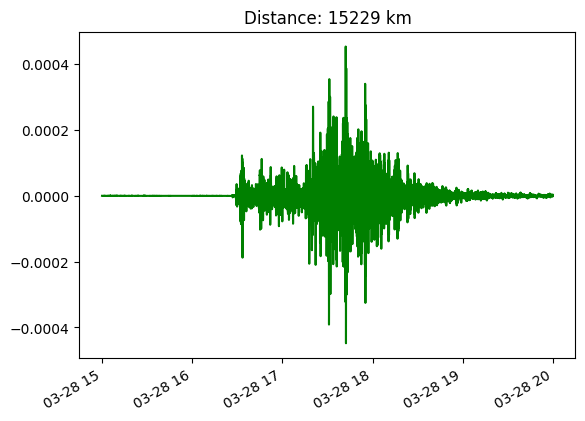

In [33]:
%matplotlib inline
plot_seismo_gcd(sac.seismogram, sac.event, sac.station)

As before we can run the function with other classes, or even mix them:

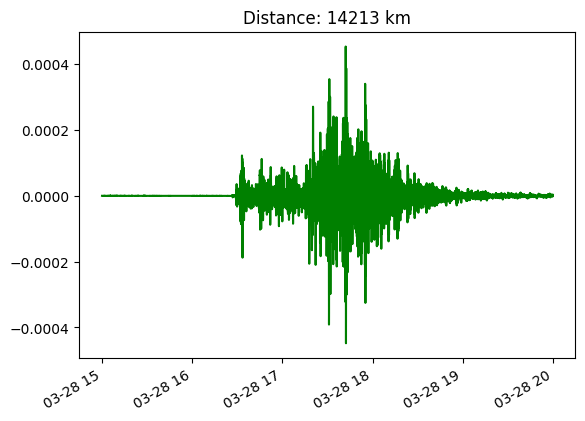

In [34]:
plot_seismo_gcd(sac.seismogram, tseisp.event, tseisp.station)

### Summary

The `Seismogram` type exemplifies the simplicity of pysmo types. It contains only four attributs and a `__len__` method (for the python `len()` function). What would typically be considered metadata in traditional seismograms (e.g. in Python classes or file formats) is not part of the type. While they may well be *stored* together, they are instead treated as their own distinct types during *processing* and therefore may need to be passed to functions seperately.

## Mini Classes

Using protocol classes to annotate functions allows for a lot of freedom when it comes to the class(es) used for storing data. Those classes may be specific to an application, file format, use a database backend, download data from the internet etc, and they will still work with pysmo types. For situations where such classes are too comprehensive or you want to potentially speed up performance, pysmo provides minimal implementations of compatible classes for each type - the pysmo "mini" classes. These classes:

- Have the same names as their respective types, but with a "Mini" prefix (e.g. the `Location` type has a `MiniLocation` class).
- Have exactly the same attributes as the types.
- Are, together with pysmo types, the only items in the base namespace (i.e. importable via `from pysmo import ...`).

### Creating a new Mini instance

The Mini classes can be instantiated by simply passing the attribute values:

In [35]:
from pysmo import MiniLocation

mini_location = MiniLocation(latitude=12, longitude=34)
print(
    f"{mini_location=} is an instance of Location: {isinstance(mini_location, Location)}"
)

mini_location=MiniLocation(latitude=12, longitude=34) is an instance of Location: True


The `MiniSeismogram` class has defaults, so an instance can be created without providing attribute values:

In [36]:
from pysmo import MiniSeismogram

mini_seismogram = MiniSeismogram()
print(
    f"{mini_seismogram=} is an instance of Seismogram: {isinstance(mini_seismogram, Seismogram)}"
)

mini_seismogram=MiniSeismogram(begin_time=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), delta=datetime.timedelta(seconds=1), data=array([], dtype=float64)) is an instance of Seismogram: True


Note that the mini classes do not allow creating new attributes:

In [37]:
try:
    mini_seismogram.custom_attribute = 123
except AttributeError as e:
    print(f"AttributeError: {e}")

AttributeError: 'MiniSeismogram' object has no attribute 'custom_attribute'


### Creating a Mini clone

Another way to create Mini instances is to clone an existing object using the `clone_to_mini()` function. For example from the `sac` object we created right at the beginning:

In [38]:
from pysmo.functions import clone_to_mini

mini_seismogram = clone_to_mini(MiniSeismogram, sac.seismogram)
print(
    f"{mini_seismogram=} is an instance of Seismogram: {isinstance(mini_seismogram, Seismogram)}"
)

mini_seismogram=MiniSeismogram(begin_time=datetime.datetime(2005, 3, 28, 15, 0, 0, 498100, tzinfo=datetime.timezone.utc), delta=datetime.timedelta(seconds=1), data=array([2.41037213e-07, 2.12793083e-07, 1.08320187e-07, ...,
       1.37353561e-06, 2.51878942e-06, 3.21547782e-06], shape=(18000,))) is an instance of Seismogram: True


After updating the attributes in the clone we can copy changes back too using `copy_from_mini()`:

In [39]:
from pysmo.functions import copy_from_mini
from datetime import datetime, timezone

mini_seismogram.begin_time = datetime.now(timezone.utc)
copy_from_mini(mini_seismogram, sac.seismogram)
print(f"New begin_time: {sac.seismogram.begin_time=}")

New begin_time: sac.seismogram.begin_time=datetime.datetime(2025, 4, 7, 16, 45, 46, 506303, tzinfo=datetime.timezone.utc)


### Summary

In order for pysmo types to be useful, there needs to be at least one class that matches the type signature. Pysmo's mini classes do exactly this in a minimal fashion. As such they are useful in situations where no other suitable class is available, or if using them as clones instead of an existing (compatible) class provides benefits in processing speed. Because of their close relationship to a particular type they are imported from the pysmo base namespace.